# Project Part 3: Adversarial, Transferability and Robustification



We recommand you to use Google Colab to edit and run this notebook. You can also install jupyter on your own computer.

In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from torch import nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Subset
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 0. Prepare data

You can familiarise yourself with MNIST, a small size dataset, on its Wikipedia article [https://en.wikipedia.org/wiki/MNIST_database](https://en.wikipedia.org/wiki/MNIST_database). MNIST is composed of 28x28 grayscaled images of handwritten digits. This is a classification task with 10 classes (10 digits).

In [3]:
# Data Loading
mnist = fetch_openml('mnist_784', as_frame=False, cache=True)


In [4]:
x = mnist["data"]
y = mnist["target"]

In [5]:
# Data exploration
print(f"Shape of x: {x.shape}")
print(f"Min, max x: {x.min(), x.max()}")
print(f"Shape of y: {y.shape}")
print(f"Classes in y: {np.unique(y)}")

Shape of x: (70000, 784)
Min, max x: (0, 255)
Shape of y: (70000,)
Classes in y: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [6]:
# Preprocessing
x = torch.from_numpy(x.astype(float)).float()
y = torch.from_numpy(y.astype(int)).type(torch.LongTensor)
# Shape
x = x.reshape(-1, 1, 28, 28)
# Scaler
x = (x - x.min()) / (x.max() - x.min())


In [7]:
# Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train, shuffle=True)

## 1. Adversarial examples

The goal of this first part is to generate adversarial examples on a simple dataset called MNIST. MNIST is a dataset of 28x28 black and white images that represents hand-written digits, and their associate label 0,1,...,9.

You can use the following ressource to help you [https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#).


1. Train a Neural Network using the PyTorch library.

The architecture of the models and the training hyper-parameters are given below.
We recommend using these parameters, the SGD optimizer and the Cross Entropy loss.


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [9]:
learning_rate = 0.001
momentum=0.9
epochs = 10
batch_size = 64


In [10]:
## YOUR CODE HERE: use SGD with the provided hyperparameters
model_0 = Net()
optimizer = torch.optim.SGD(model_0.parameters(), lr=learning_rate, momentum=momentum)

In [11]:
## YOUR CODE HERE: use CrossEntropyLoss.
loss_func = nn.CrossEntropyLoss()

In [12]:
def train_loop(dataloader, model, loss_fn, optimizer):
  running_loss = 0.0
  correct = 0
  total = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
    # move data to device
    images, labels = X.to(device), y.to(device)
    # compute prediction and loss: forward pass
    ## YOUR CODE HERE:
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    # backpropagation
    ## YOUR CODE HERE:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # loss and accuracy
    running_loss += loss.item()
    _, predicted = outputs.max(1)
    correct += predicted.eq(labels).sum().item()
  epoch_loss = running_loss / len(dataloader)
  epoch_accuracy = 100 * correct / total
  return epoch_loss, epoch_accuracy

In [13]:
## GIVEN, to evaluate the progress of the training at each epoch
def val_loop(dataloader, model, loss_fn, epoch_i):
  total = len(dataloader.dataset)
  test_loss, correct = 0, 0
  model.eval() # IMPORTANT: set model to evaluation
  with torch.no_grad():
    for X, y in dataloader:
      images, labels = X.to(device), y.to(device)
      pred = model(images)
      test_loss += loss_fn(pred, labels).item()
      correct += (pred.argmax(1) == labels).type(torch.float).sum().item()
  test_loss /= len(dataloader)
  accuracy = 100 * correct / total  # convert to percentage for consistency with training accuracy
  print(f"Epoch {epoch_i}, Val Error: Accuracy: {accuracy:>0.1f}%, Avg loss: {test_loss:>8f}")
  return test_loss, accuracy

In [14]:
def plot_training(training_losses, validation_losses, training_accuracies, validation_accuracies):
    # plot results
    clear_output(wait=True)
    plt.figure(figsize=(16, 10))
    # training loss
    plt.subplot(2, 2, 1)
    plt.plot(range(1, len(training_losses) + 1), training_losses, marker="o", linestyle="-", color="b")
    plt.title("Training Loss Convergence")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    # validation loss
    plt.subplot(2, 2, 2)
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, marker="o", linestyle="-", color="orange")
    plt.title("Validation Loss Convergence")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    # training accuracy
    plt.subplot(2, 2, 3)
    plt.plot(range(1, len(training_accuracies) + 1), training_accuracies, marker="o", linestyle="-", color="g")
    plt.title("Training Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    # validation accuracy
    plt.subplot(2, 2, 4)
    plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, marker="o", linestyle="-", color="purple")
    plt.title("Validation Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    # plot
    plt.tight_layout()
    plt.show()

def train_model(model, x_train, y_train, x_val, y_val, optimizer, batch_size, loss_func, epochs):
    # move model to device
    model.to(device)
    # data processing
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
    )
    val_dataset = TensorDataset(x_val, y_val)
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size, # set batch_size to batch_size
        shuffle=False, # no shuffling for validation data
        num_workers=2,
    )
    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []
    # Main train loop
    for epoch in range(epochs):
      training_loss, training_accuracy = train_loop(train_loader, model, loss_func, optimizer)
      validation_loss, validation_accuracy = val_loop(val_loader, model, loss_func, epoch + 1)

      training_losses.append(training_loss)
      training_accuracies.append(training_accuracy)
      validation_losses.append(validation_loss)
      validation_accuracies.append(validation_accuracy)
      # plot results
      plot_training(training_losses, validation_losses, training_accuracies, validation_accuracies)

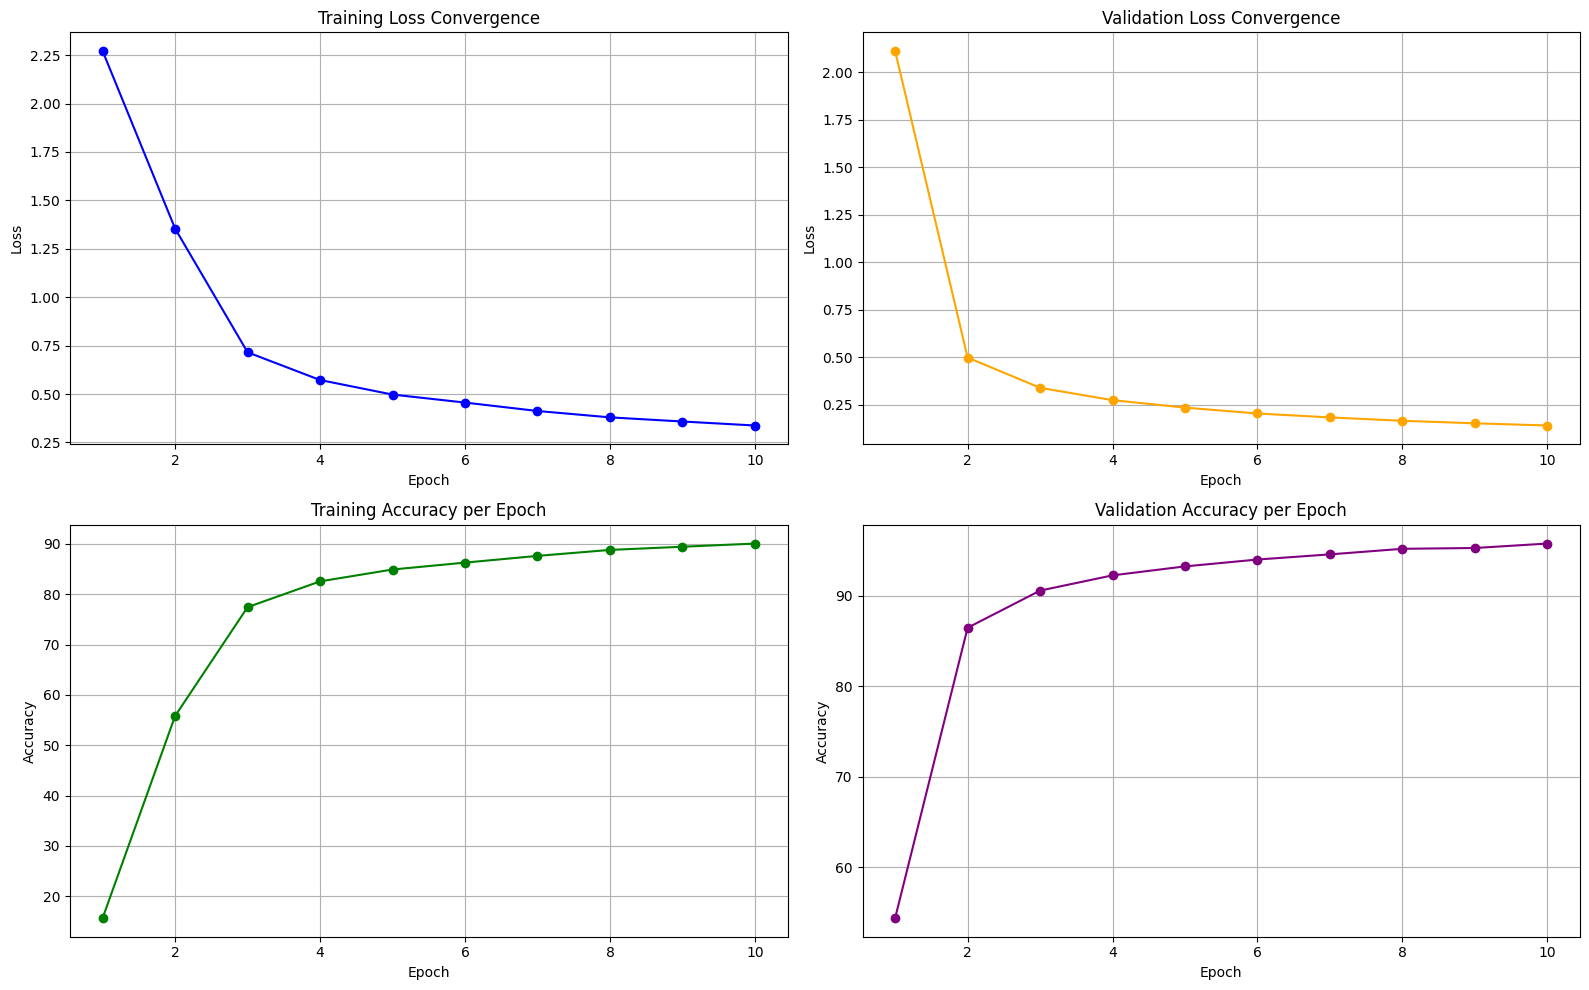

In [15]:
## YOUR CODE HERE: train the model using the training function you just implemented.
train_model(
    model=model_0,
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    optimizer=optimizer,
    batch_size=batch_size,
    loss_func=loss_func, epochs=epochs)

2. Evaluate clean accuracy of the Neural Network using a test set that has not been used for training.

In [16]:
# Set model into evaluation mode
model_0.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [17]:
## YOUR CODE HERE: Evaluate model accuracy

# create a DataLoader for the test set
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

def evaluate_accuracy(dataloader, model):
    model.eval()  # set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in dataloader:
            images, labels = X.to(device), y.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

# calculate accuracy
accuracy = evaluate_accuracy(test_loader, model_0)
print(f"Clean accuracy of the model is {accuracy:.2f}%.")

Clean accuracy of the model is 95.70%.


3. Implement and execute the PGD attack on 1000 examples of the testing set. The hyperparameters of PGD are given below.
The perturbation is bounded by a maximum L-infinity norm, called epsilon (eps), which means that each pixel can be perturbed between -eps and +eps. We initialy set the maximum perturbation to eps = 32/255. For simplicity, you can set the step size alpha = epsilon / 10, and run PGD with only one random restart.

You can find the description of PGD in the paper [https://arxiv.org/abs/1706.06083](https://arxiv.org/abs/1706.06083) and an example of another adversarial attack on the PyTorch documentation [https://pytorch.org/tutorials/beginner/fgsm_tutorial.html](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html).
Tips: use the F.cross_entropy loss during the attack.


In [18]:
n_examples = 1000
eps = 32/255
n_iter = 50
alpha = eps / 10


In [19]:
## YOUR CODE HERE: Generate adversarial examples

# FGSM attack for reference
def fgsm_attack(model, images, labels, eps):
    """
    Implements the FGSM attack, a one-step attack where the perturbation is added in the direction of the gradient with magnitude epsilon.
    """
    # make a copy of the images and require gradients for it
    perturbed_images = images.clone().detach().to(device)
    perturbed_images.requires_grad = True
    # forward pass to calculate the loss
    outputs = model(perturbed_images)
    loss = F.cross_entropy(outputs, labels)
    # backward pass to get the gradient of the loss w.r.t. the images
    model.zero_grad()
    loss.backward()
    # apply FGSM update
    perturbed_images = perturbed_images + eps * perturbed_images.grad.sign()
    # clip the images to be within the valid pixel range
    perturbed_images = torch.clamp(perturbed_images, min=0, max=1).detach()
    return perturbed_images

# PGD attack
def pgd_attack(model, images, labels, eps, alpha, n_iter):
    """
    Implements the PGD attack, which is an extension of FGSM attack. It is an iterative attack where small steps of size alpha are taken in the direction of the gradient.
    Keeps the perturbations constrained to a small region around the original input defined by an l_infinity norm, i.e. between [-eps, +eps].
    """
    # clone images, detach them from the previous computation graph, and set requires_grad=True
    original_images = images.clone().detach().to(device)
    perturbed_images = images.clone().detach().to(device)
    perturbed_images.requires_grad = True
    # iterate n_iter times and apply perturbation
    for i in range(n_iter):
        # forward pass to calculate the loss
        outputs = model(perturbed_images)
        loss = F.cross_entropy(outputs, labels)
        # backward pass to get the gradient of the loss w.r.t. the images
        model.zero_grad()
        loss.backward()
        # apply PGD update: take a small step in the direction of the gradient
        sign_data_grad = perturbed_images.grad.data.sign()
        perturbed_images = perturbed_images + alpha * sign_data_grad
        # project the perturbation within the allowed range
        perturbation = torch.clamp(perturbed_images - original_images, min=-eps, max=eps)
        perturbed_images = torch.clamp(original_images + perturbation, min=0, max=1)
        # detach perturbed_images and re-enable requires_grad for the next iteration
        # otherwise PyTorch throws RuntimeError: you can only change requires_grad flags of leaf variables.
        perturbed_images = perturbed_images.detach()
        perturbed_images.requires_grad = True
    return perturbed_images

4. Show the robust accuracy of model_0, that is the accuracy of the model on the adversarial examples.

In [20]:
## YOUR CODE HERE: Evaluate model robust accuracy

# 1. take n_examples subset from testloader
test_subset = Subset(test_loader.dataset, range(n_examples))
test_loader_limited = DataLoader(
    test_subset,
    batch_size=test_loader.batch_size,
    shuffle=False,
    num_workers=test_loader.num_workers
)

# 2. evaluate the model when data is attacked using pgd algorithm
def evaluate_perturbation(dataloader, model, eps, alpha, n_iter):
    model.eval() # to avoid randomness by layers such as dropout, important for pgd attack
    results = []  # store results for each example
    correct = 0
    total = 0
    for X, y in dataloader:
        images, labels = X.to(device), y.to(device)
        # set requires_grad attribute of tensor. Important for Attack
        images.requires_grad = True
        # apply pgd attack on input data
        perturbed_images = pgd_attack(model, images, labels, eps, alpha, n_iter)
        # disable gradient tracking for evaluation after attack
        with torch.no_grad():
            # get predictions on original and perturbed images
            original_outputs = model(images)
            perturbed_outputs = model(perturbed_images)
            original_preds = original_outputs.max(1)[1]
            perturbed_preds = perturbed_outputs.max(1)[1]
            # store results
            for i in range(len(labels)):
                result = {
                    "original_image": images[i].cpu().squeeze().detach().numpy(),
                    "adversarial_image": perturbed_images[i].cpu().squeeze().detach().numpy(),
                    "original_pred": original_preds[i].item(),
                    "adversarial_pred": perturbed_preds[i].item(),
                    "true_label": labels[i].item()
                }
                results.append(result)
            # check if the prediction is correct/wrong
            _, predicted = perturbed_outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    total_accuracy = 100 * correct / total
    return results, total_accuracy

# calculate adversarial accuracy
model0_results, accuracy_perturbated = evaluate_perturbation(test_loader_limited, model_0, eps, alpha, n_iter)
print(f"Perturbated accuracy of the model is {accuracy_perturbated:.2f}%.")


Perturbated accuracy of the model is 54.10%.


5. Show the impact of the maximum perturbation allowed (denoted epsilon).

In [21]:
epss = [8/255, 16/255, 32/255, 64/255]
alphas = [e/10 for e in epss]

In [22]:
## YOUR CODE HERE: compute the adversarial examples for each provided epsilon
## (maximum l-infinity norm of the perturbation), and compute the associated robust accuracy
## Use a graph to display your result. You may use the [Matplotlib] (https://matplotlib.org/stable/index.html).

accuracies_model0 = []
for eps, alpha in zip(epss, alphas):
    _, accuracy = evaluate_perturbation(test_loader_limited, model_0, eps, alpha, n_iter)
    accuracies_model0.append([eps, alpha, accuracy])

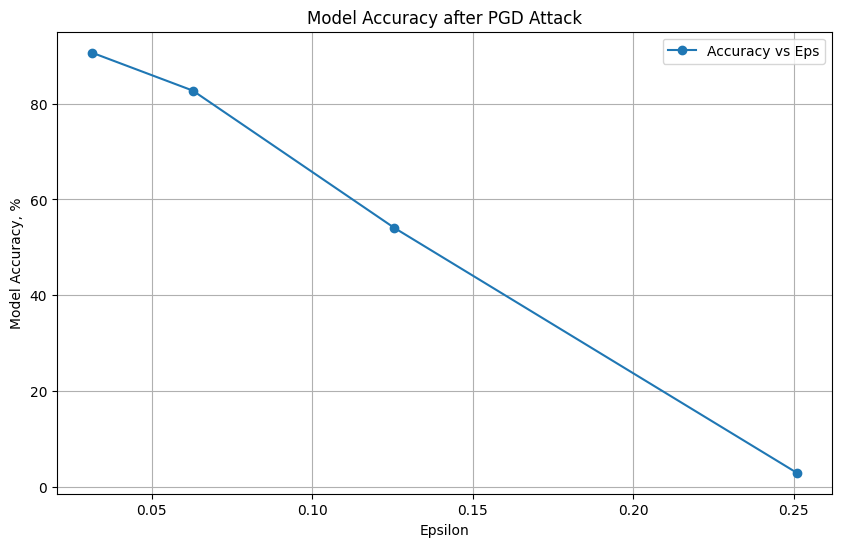

In [23]:
df_results_model0 = pd.DataFrame(accuracies_model0, columns=["eps", "alpha", "accuracy"])
plt.figure(figsize=(10, 6))
plt.plot(df_results_model0["eps"], df_results_model0["accuracy"], marker="o", label="Accuracy vs Eps")
plt.xlabel("Epsilon")
plt.ylabel("Model Accuracy, %")
plt.title("Model Accuracy after PGD Attack")
plt.grid(True)
plt.legend()
plt.show()

6. Using matplotlib, plot 10 adversarial examples, along with their corresponding original images. Choose one original image classified per class (the 10 class should be represented). For each image (adversarial and original), add on the plot the predicted class of the image.


In [24]:
def get_adversarial_samples(results):
    # dictionary to store one adversarial example per class for plotting
    class_samples = {i: None for i in range(10)}
    collected_samples = 0  # count of collected unique class samples
    # iterate over the results and collect one adversarial example per class
    for result in results:
        label = result["true_label"]
        # store original and perturbated images only if
        # the original prediction was correct
        # and the adversarial prediction is wrong
        if (class_samples[label] is None and result["original_pred"] == label and result["adversarial_pred"] != label):
            # store the example
            class_samples[label] = {
                "original_image": result["original_image"],
                "adversarial_image": result["adversarial_image"],
                "original_pred": result["original_pred"],
                "adversarial_pred": result["adversarial_pred"]
            }
            collected_samples += 1
            # break if we have collected one example for each class
            if collected_samples >= 10:
                break
    return class_samples

In [25]:
class_samples = get_adversarial_samples(model0_results)


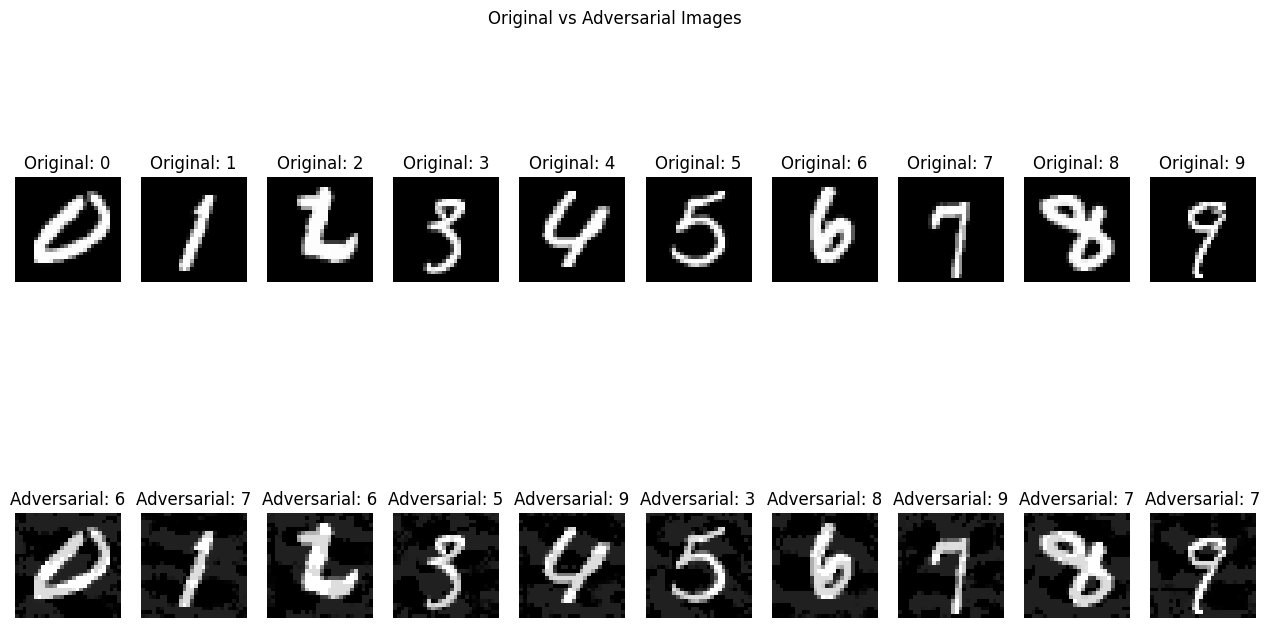

In [26]:
# plot the images
plt.figure(figsize=(16, 8))
for i, (label, sample) in enumerate(class_samples.items()):
    original_image = sample["original_image"]
    adversarial_image = sample["adversarial_image"]
    original_pred = sample["original_pred"]
    adversarial_pred = sample["adversarial_pred"]
    # original image
    plt.subplot(2, 10, i + 1)
    plt.imshow(original_image, cmap="gray")
    plt.title(f"Original: {original_pred}")
    plt.axis("off")
    # adversarial image
    plt.subplot(2, 10, i + 11)
    plt.imshow(adversarial_image, cmap="gray")
    plt.title(f"Adversarial: {adversarial_pred}")
    plt.axis("off")

plt.suptitle("Original vs Adversarial Images")
plt.show()

**Question**: Please comment your results of this section.

**ANSWER HERE**

We clearly see the impact of the PGD attack on the model's robustness. As we increase `eps` (and therefore `alpha`), the model's accuracy significantly declines. This is expected, as `alpha` represents the step size for each perturbation, indicating how much the input data is modified.

Looking at the plot of original images, adversarial (perturbed) images, and their corresponding model predictions, we can see that while the perturbed images still appear easily recognizable to a human, the model struggles to classify them correctly. This might mean that the model isn't focusing on the essential parts of the image to identify the class reliably. Visually, each digit in the perturbed image closely resembles its original version, with only slight changes, such as a dark gray background instead of pure black. These minor changes shouldn't mislead the model, as they don't alter the structure of the digit itself, which is the most important feature for accurate classification.


## 2. Transferability

In this section we will see how adversarial examples generated on one model can be adversarial on another model using a different architecture.
Let suppose a second model which parameters are unknown. For instance, it could be a model deploy on a cloud platform. We will use the examples generated in Section 1 on model_0 to fool this new model denoted model_1.
We say that model_0 is a surrogate for model_1.

1. Define a neural network architecture for MNIST different than the one used in Section 1.

In [27]:
## GIVEN
class FullyConnectedNetwork(nn.Module):
    def __init__(self):
        super(FullyConnectedNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

2. Train the neural network model_1 with the same hyperparameters as model_0


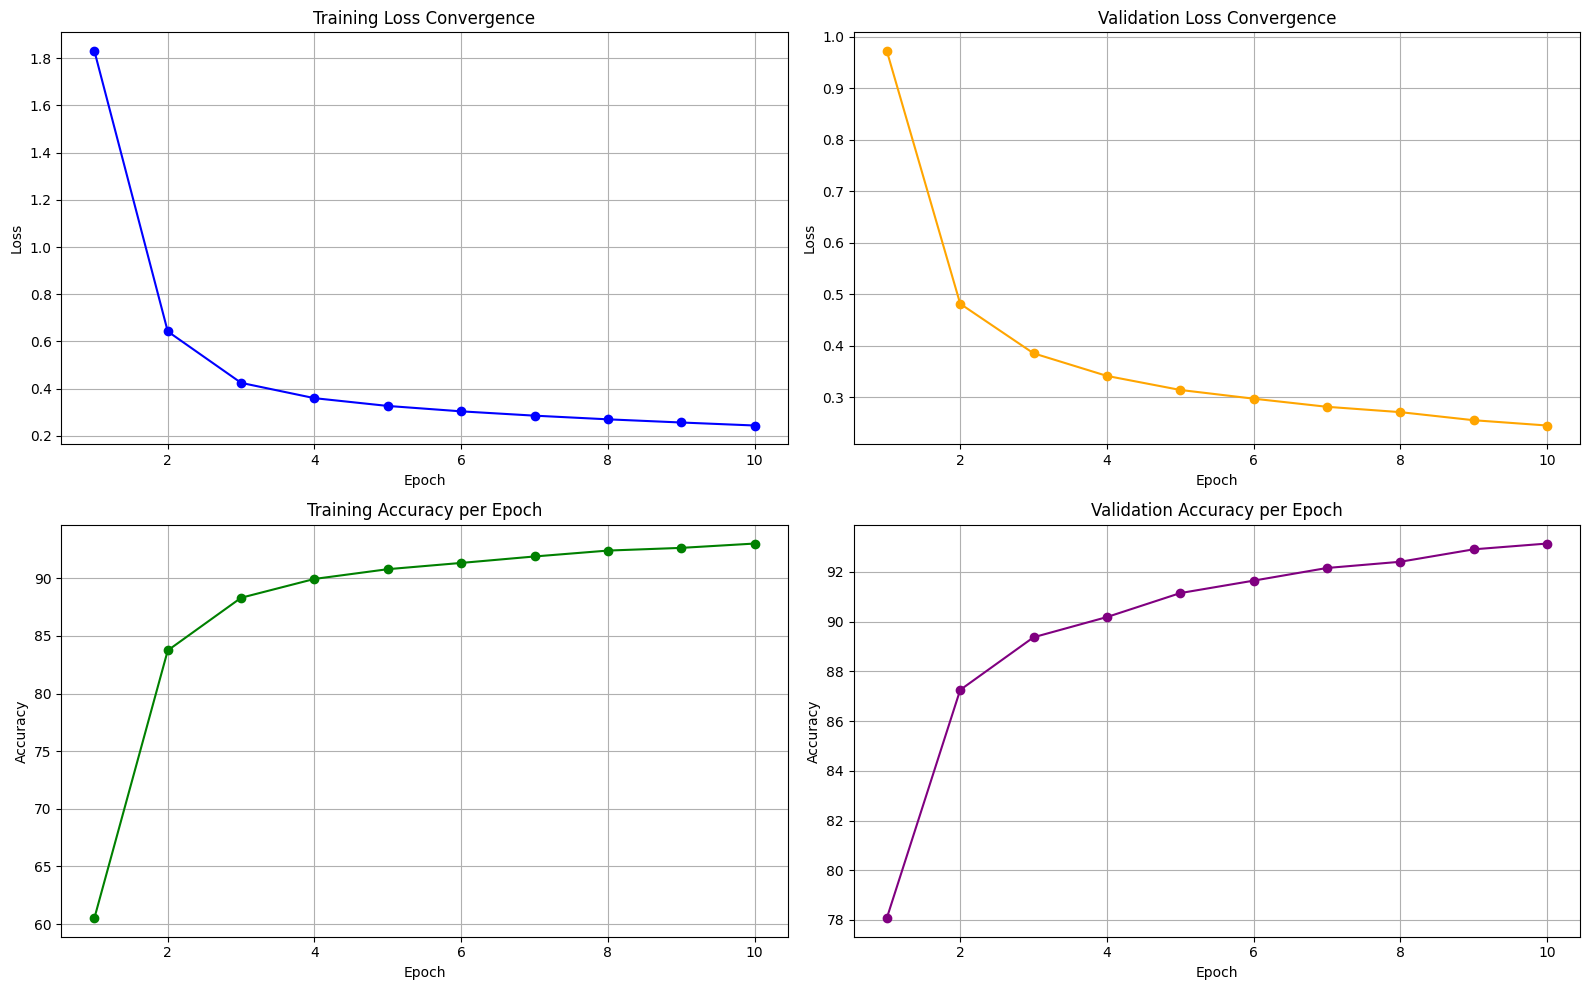

In [28]:
## YOUR CODE HERE
learning_rate = 0.001 # same as for model_0
momentum=0.9 # same as for model_0
epochs = 10 # same as for model_0
batch_size = 64 # same as for model_0
model_1 = FullyConnectedNetwork().to(device)
optimizer_1 = torch.optim.SGD(model_1.parameters(), lr=learning_rate, momentum=momentum)  # create a new optimizer object when you train a new model
train_model(
    model=model_1,
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    optimizer=optimizer_1,
    batch_size=batch_size,
    loss_func=loss_func, epochs=epochs
)

3. What is the ratio of successful adversarial examples on model_0 that transfers to model_1 (ie. that are also adversarial for model_1)?

$$
\text{Transfer Ratio}=\frac{\text{Number of adversarial examples that fool both models}}{\text{Number of adversarial examples that fool model\_0}}
$$

In [29]:
model_1.eval()
## YOUR CODE HERE
# calculate accuracy
accuracy = evaluate_accuracy(test_loader, model_1)
print(f"Clean accuracy of the model is {accuracy:.2f}%.")
# calculate adversarial accuracy
n_examples = 1000
eps = 32/255
n_iter = 50
alpha = eps / 10
model1_results, accuracy_perturbated = evaluate_perturbation(test_loader_limited, model_1, eps, alpha, n_iter)
print(f"Perturbated accuracy of the model is {accuracy_perturbated:.2f}%.")

Clean accuracy of the model is 92.59%.
Perturbated accuracy of the model is 12.70%.


In [30]:
num_fool_model0 = 0
num_fool_both = 0
for i in range(n_examples):
    true_label = model0_results[i]["true_label"]
    model0_adv_pred_label = model0_results[i]["adversarial_pred"]
    model1_adv_pred_label = model1_results[i]["adversarial_pred"]
    # count examples that fool model_0
    if true_label != model0_adv_pred_label:
        num_fool_model0 += 1
        # count examples that fool both model_0 and model_1
        if true_label != model1_adv_pred_label:
            num_fool_both += 1
transfer_ratio = num_fool_both / num_fool_model0 if num_fool_model0 > 0 else 0
print(f"Transfer ratio: {transfer_ratio}")

Transfer ratio: 0.9978213507625272


What do you conclude about the robustness of the model? Can [secrecy](https://en.wikipedia.org/wiki/Security_through_obscurity) defend a model?

**ANSWER HERE**

Transfer ratio is 0.99, which suggests that the adversarial examples generated to fool `model_0` are highly transferable and also effective to fool `model_1`. Even though we changed the architecture from CNN to FC, the adversarial perturbations generated using PGD attack still produced good results (low model accuracies).

High transfer ratio indicates a lack of robustness across models, suggesting that neither `model_0` nor `model_1` has learned features that are resilient PGD adversarial attack. Since PGD attack algorithm does not consider the architecture of the model, high transfer ratio suggests that model **secrecy** is insufficient to defend against adversarial attacks.

## 3. Use adversarial training to robustify the model

Adversarial training is a common method to robustify models to adversarial examples as described in this paper [https://arxiv.org/abs/1706.06083](https://arxiv.org/abs/1706.06083). In this section you should update the training loop such that 3/4 of the batch is used for training while the remaining forth is first perturbed with PGD and then used for training. You can limit the number of iterations of PDG to 10. Use model_0 architecture from Section 1 in this section.

1. Train model_robust using adversarial training. You may want to run it for additional epoch (x2) to reach a similar clean accuracy.

In [31]:
n_iter = 10  # less iterations to accelerate training. But once trained, we will still evaluate the robust accuracy on more iterations for a more powerful attack.
eps = 32/255
alpha = eps / 5
learning_rate = 0.001
momentum=0.9
epochs = 20 # x2 epochs
batch_size = 64

model_robust = Net()  # newly initialized NN
optimizer_robust = torch.optim.SGD(model_robust.parameters(), lr=learning_rate, momentum=momentum) # newly initialized optimizer
loss_func = nn.CrossEntropyLoss()

In [32]:
def train_loop_adv(dataloader, model, loss_fn, optimizer, batch_size, eps, alpha, n_iter):
    size = len(dataloader.dataset)
    adv_size = int(batch_size/4)
    clean_size = 3 * adv_size
    running_loss = 0.0
    correct = 0
    total = len(dataloader.dataset)
    for batch, (X, y) in tqdm(enumerate(dataloader), total=int(size/batch_size)):
        images, labels = X.to(device), y.to(device)
        # Generate adversarial examples for a forth of the data
        ## YOUR CODE HERE:
        # shuffle the batch to ensure different images are selected each time
        indices = torch.randperm(batch_size)
        images, labels = images[indices], labels[indices]
        # split into 3/4 and 1/4 batches
        images_real, images_adv = images[:clean_size], images[clean_size:]
        labels_real, labels_adv = labels[:clean_size], labels[clean_size:]
        # generate adversarial examples for 1/4 of the batch
        model.eval()
        images_adv.requires_grad = True
        perturbed_images = pgd_attack(model, images_adv, labels_adv, eps, alpha, n_iter)
        # combine perturbed data and 3/4 of the original data back into a single batch
        images_all = torch.cat([images_real, perturbed_images])
        labels_all = torch.cat([labels_real, labels_adv])
        # Train the model on the combined batch
        ## YOUR CODE HERE:
        model.train()
        outputs = model(images_all)
        loss = loss_fn(outputs, labels_all)
        # Backpropagation
        ## YOUR CODE HERE:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy

def train_model_adv(model, x_train, y_train, x_val, y_val, optimizer, batch_size, loss_func, epochs, eps, alpha, n_iter):
    # move model to device
    model.to(device)
    # data processing
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
    )
    val_dataset = TensorDataset(x_val, y_val)
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size, # set batch_size to batch_size
        shuffle=False, # no shuffling for validation data
        num_workers=2,
    )
    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []
    # Main train loop
    for epoch in range(epochs):
      training_loss, training_accuracy = train_loop_adv(train_loader, model, loss_func, optimizer, batch_size, eps, alpha, n_iter)
      validation_loss, validation_accuracy = val_loop(val_loader, model, loss_func, epoch + 1)

      training_losses.append(training_loss)
      training_accuracies.append(training_accuracy)
      validation_losses.append(validation_loss)
      validation_accuracies.append(validation_accuracy)
      # plot results
      plot_training(training_losses, validation_losses, training_accuracies, validation_accuracies)

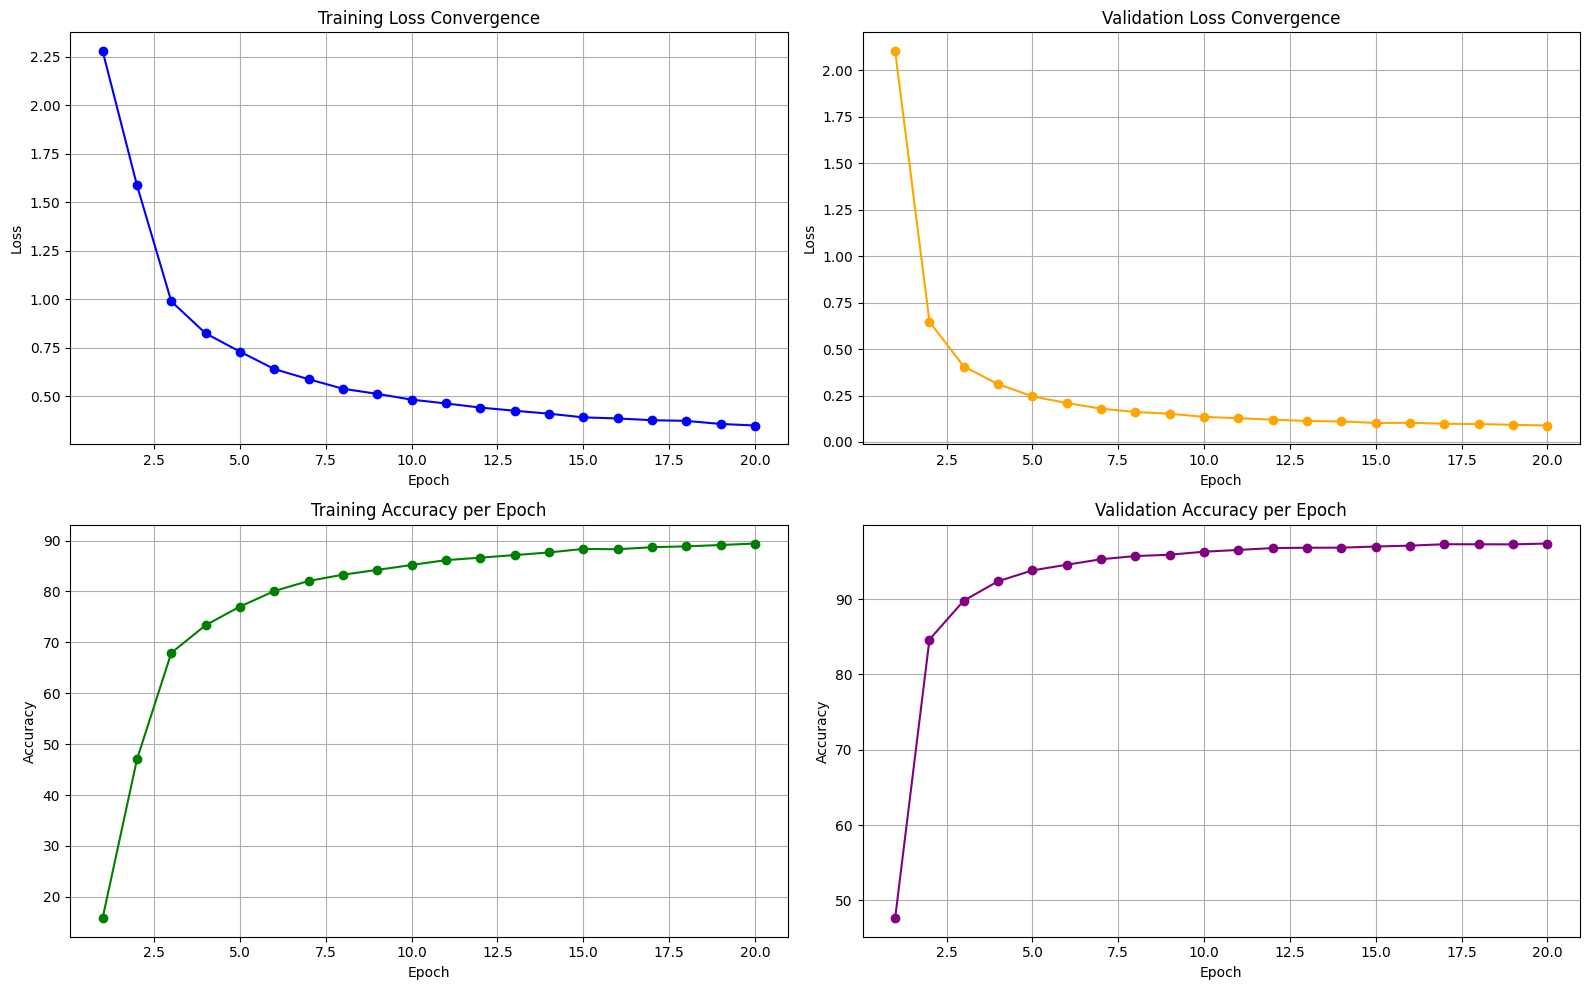

In [33]:
## YOUR CODE HERE: The rest of training implementation is unchanged.
## Do not reuse the same optimizer object!!!
train_model_adv(
    model=model_robust,
    x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val,
    optimizer=optimizer_robust,
    batch_size=batch_size,
    loss_func=loss_func, epochs=epochs,
    eps=eps, alpha=alpha, n_iter=n_iter
)

2. Compare the robust accuracies of model_0 and model_robust using the same hyperparameters of PGD for different eps size, use a graph to show your results.

In [34]:
n_examples = 1000
n_iter = 50
epss = [8/255, 16/255, 32/255, 64/255]
alphas = [e/10 for e in epss]

In [35]:
## YOUR CODE HERE
accuracies_modelrobust = []
for eps, alpha in zip(epss, alphas):
    _, accuracy = evaluate_perturbation(test_loader_limited, model_robust, eps, alpha, n_iter)
    accuracies_modelrobust.append([eps, alpha, accuracy])
df_results_robust = pd.DataFrame(accuracies_modelrobust, columns=["eps", "alpha", "accuracy"])

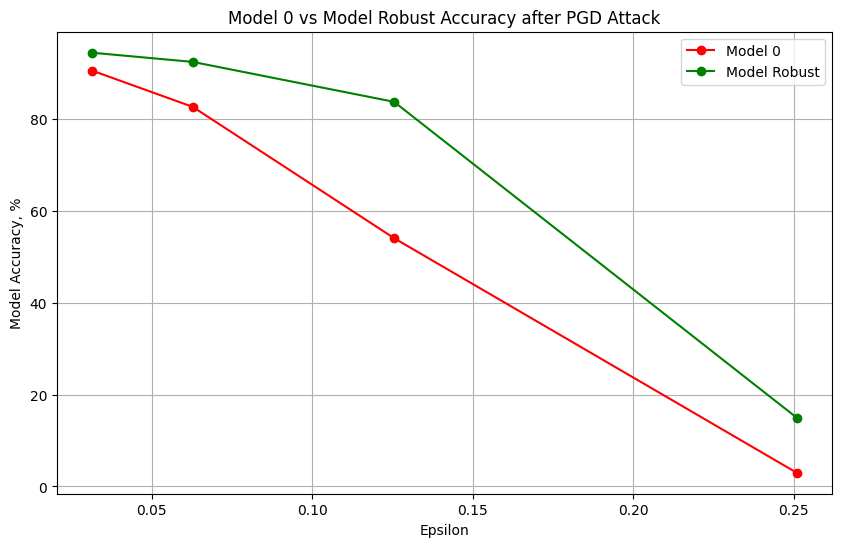

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(df_results_model0["eps"], df_results_model0["accuracy"], marker="o", label="Model 0", color="r")
plt.plot(df_results_robust["eps"], df_results_robust["accuracy"], marker="o", label="Model Robust", color="g")
plt.xlabel("Epsilon")
plt.ylabel("Model Accuracy, %")
plt.title("Model 0 vs Model Robust Accuracy after PGD Attack")
plt.grid(True)
plt.legend()
plt.show()

**Questions**: Please comment your results. Does adversarial training appears to be a valid defense? Please develop threads to validity of the robust accuracy evaluation carried out here. What could be done to improve the evaluation of the robustness of the model?

**ANSWER HERE**

- The plot shows that the adversarially trained model (`model_robust`) consistently outperforms the non-adversarially trained model (`model_0`) at different levels of attack strength (`epsilon`). This suggests that adversarial training has improved the model's robustness, i.e. its ability to withstand data perturbations and maintain higher accuracy under perturbation attacks. We also notice that the rate of degradation (`accuracy` decline as `epsilon` increases) is slower for the adversarially trained model, indicating that it is more resilient to stronger attacks.
- If we evaluate the robustness of the model using only `accuracy vs epsilon` graph, we can deduce that adversarial training is a valid defense against PGD adversarial attacks. It improves model robustness and might even improve the model generalization power (if we look at adversarial training as a way to augment the training dataset). However, it is important to remember that adversarial training requires more computational resources and training time, as the process involves generating adversarial examples in each batch and retraining on them.
- Since the evaluation is conducted using a fixed set of parameters (a set range of `epsilon` values, `alpha`, and a fixed number `n_iter`), they may not fully represent all possible adversarial threats. To improve the evaluation of the robustness of the model, we can try out these methods:
  1. **Increase** the number of **iterations** (`n_iter`) in `evaluate_perturbation` function, which could produce stronger attacks and expose weaknesses in the adversarially trained model.
  2. **Increase** the **ranges of parameters** `epsilon` and `alpha`.
  3. Try out **different attack types** rather than just PGD attack during evaluation.
  4. Evaluate the robustness of the models on the **full test dataset** or a larger, representative subset to ensure the results are not sample-dependent.
- In conclusion, increasing iterations and parameter ranges could show the model's limits under more intense attacks; introducing different attack types would evaluate the model against various adversarial strategies, not just a single one; evaluating the model on the full test dataset or a larger subset ensures the evaluation is not biased by a small sample size.